In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import networkx as nx
import uuid
import copy

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Useful functions

In [191]:
def als_solve(A, B):
    return torch.linalg.lstsq(A, B).solution
def unfold(tensor, mode):
    """
    Unfolds an n-th order tensor along the specified mode.
    
    Args:
        tensor (torch.Tensor): Input tensor of shape (d0, d1, ..., dn)
        mode (int): Mode along which to unfold (0-based)
        
    Returns:
        torch.Tensor: The mode-i unfolding of shape (tensor.size(mode), -1)
    """
    # Move the mode to the first dimension
    new_order = [mode] + [i for i in range(tensor.ndim) if i != mode]
    permuted = tensor.permute(new_order)
    
    # Flatten all dimensions except the first (which is mode)
    unfolded = permuted.reshape(tensor.shape[mode], -1)
    return unfolded
def fold(unfolded, mode, shape):
    """
    Refolds a matrix back into a tensor of given shape along a mode.
    
    Args:
        unfolded (torch.Tensor): Unfolded matrix of shape (shape[mode], -1)
        mode (int): Mode along which it was unfolded (0-based)
        shape (tuple): Original shape of the tensor before unfolding
        
    Returns:
        torch.Tensor: The refolded tensor of shape `shape`
    """
    # Calculate the shape after permuting mode to front
    new_order = [mode] + [i for i in range(len(shape)) if i != mode]
    inverse_order = list(torch.argsort(torch.tensor(new_order)))

    # Compute the shape of the permuted tensor
    permuted_shape = (shape[mode], -1)
    reshaped = unfolded.reshape([shape[mode]] + [shape[i] for i in range(len(shape)) if i != mode])

    # Invert the permutation to get original order
    folded = reshaped.permute(*inverse_order)
    return folded
def unfold_to_matrix(x: torch.Tensor, dims_to_rows: list[int]) -> torch.Tensor:
    """
    Unfolds a tensor into a matrix, flattening `dims_to_rows` into rows,
    and the rest into columns.

    Args:
        x (torch.Tensor): The input tensor.
        dims_to_rows (list[int]): Dimensions to flatten into the row axis.

    Returns:
        torch.Tensor: A 2D tensor (matrix) of shape (prod(dims_to_rows), prod(other_dims)).
    """
    all_dims = list(range(x.ndim))
    dims_to_cols = [d for d in all_dims if d not in dims_to_rows]

    # Permute to bring row dims first, then col dims
    permuted_dims = dims_to_rows + dims_to_cols
    x_permuted = x.permute(permuted_dims)

    # Compute new shape
    row_size = int(torch.prod(torch.tensor([x.shape[d] for d in dims_to_rows])))
    col_size = int(torch.prod(torch.tensor([x.shape[d] for d in dims_to_cols])))

    return x_permuted.reshape(row_size, col_size)
def get_inverse_perm(p):
    r = []
    for i in range(len(p)):
        # Busquem i en p, la seva pos s'afegeix a r
        for j in range(len(p)):
            if p[j] == i:
                r.append(j)
                break
    return r
def find_permutation(X, Y):
    """
    Returns a list of indices such that applying this permutation to X results in Y.
    Works with unhashable elements.
    """
    if len(X) != len(Y):
        raise ValueError("X and Y must be of the same length.")

    used = [False] * len(Y)
    permutation = []

    for x in X:
        found = False
        for i, y in enumerate(Y):
            if not used[i] and x == y:
                permutation.append(i)
                used[i] = True
                found = True
                break
        if not found:
            raise ValueError("Y is not a permutation of X.")

    return permutation

In [192]:
t = torch.randn(2,2,2,2)
print(t)
print(unfold_to_matrix(t, [1,2]))

print(find_permutation([1,2,3,4], [4,2,1,3]))

tensor([[[[ 0.2139,  0.3517],
          [ 0.4914,  1.0253]],

         [[ 1.1081, -2.1376],
          [ 1.1577,  2.3486]]],


        [[[ 0.3604, -1.2108],
          [-1.3382, -0.7320]],

         [[-0.7788,  1.5387],
          [ 1.0865, -1.6822]]]])
tensor([[ 0.2139,  0.3517,  0.3604, -1.2108],
        [ 0.4914,  1.0253, -1.3382, -0.7320],
        [ 1.1081, -2.1376, -0.7788,  1.5387],
        [ 1.1577,  2.3486,  1.0865, -1.6822]])
[2, 1, 3, 0]


# TN Class

In [707]:
class TN():
    def initTensor(self, shape):
        return torch.randn(shape, device=device)
    def __init__(self, G, sizes, ranks):
        if len(G.edges) != len(ranks):
            raise Exception("Rank length must be equal to the number of edges")
        if len(G.nodes) != len(sizes):
            raise Exception("Sizes length must be equal to the number of nodes")
        self.data = {}
        self.tensors = {}
        # Init data
        i = 0
        for node in G.nodes:
            self.data[node] = [ [sizes[i], -1, i] ]
            i += 1
        i = 0
        for e in G.edges:
            node1, node2 = (e[0], e[1])
            h = uuid.uuid4()
            self.data[node1] += [  [ranks[i], h] ]
            self.data[node2] += [  [ranks[i], h]  ]
            i += 1
        i = 0
        for node in G.nodes:
            shape = []
            for x in self.data[node]:
                shape.append(x[0])
            self.tensors[node] = self.initTensor(shape)
            i += 1
        # print(self.data)
        # print(self.tensors)
    def set_core(self, tensor, node):
        self.tensors[node] = tensor
    def get_core(self, node):
        return self.tensors[node]
    def get_tn_size(self):
        s = 0
        for k in self.tensors.keys():
            s += torch.numel(self.tensors[k])
        return s
    def contract(self, node1, node2, newnode):
        # Compute other indexes
        dim1 = []
        dim2 = []
        for i in range(len(self.data[node1])):
            for j in range(len(self.data[node2])):
                if self.data[node1][i][1] == -1 or self.data[node2][j][1] == -1:
                    continue
                if self.data[node1][i][1] == self.data[node2][j][1]:
                    dim1.append(i)
                    dim2.append(j)
        # print(dim1)
        # print(dim2)
        ts = []
        for i in range(len(self.data[node1])):
            if i not in dim1:
                ts.append(self.data[node1][i])
        for i in range(len(self.data[node2])):
            if i not in dim2:
                ts.append(self.data[node2][i])
        # Compute
        t = torch.tensordot(self.tensors[node1], self.tensors[node2], dims=(dim1, dim2))
        self.data[newnode] = ts
        self.tensors[newnode] = t

        del self.data[node1]
        del self.data[node2]
        del self.tensors[node1]
        del self.tensors[node2]

        # print()
        # print(self.data)
        # for x in self.tensors.keys():
        #    print(self.tensors[x].shape)
    @staticmethod
    def eval(t):
        tn = copy.deepcopy(t)
        p = len(tn.data) + 1
        while len(tn.data) > 1:
            klist = list(tn.data.keys())
            x = klist[0]
            y = klist[1]
            tn.contract(x, y, p)
            p += 1
        # TODO: Fer reshape al return ja que les dims estàn cambiades!
        perm = [[y[2] for y in tn.data[p-1]].index(x) for x in range(len(tn.data[p-1]))]
        return torch.permute(tn.tensors[p-1], perm)

    @staticmethod
    def same_eval(t):
        tn = copy.deepcopy(t)
        p = len(tn.data) + 1
        while len(tn.data) > 1:
            klist = list(tn.data.keys())
            x = klist[-1]
            y = klist[-2]
            tn.contract(x, y, p)
            p += 1
        # TODO: Fer reshape al return ja que les dims estàn cambiades!
        perm = [[y[2] for y in tn.data[p-1]].index(x) for x in range(len(tn.data[p-1]))]
        return torch.permute(tn.tensors[p-1], perm)
    
    @staticmethod
    def get_contraction_except(tn, core):
        t = copy.deepcopy(tn)
        p = len(t.data) + 1
        while len(t.data) > 2:
            klist = list(t.data.keys())
            e = [klist[0], klist[1], klist[2]]
            if core in e:
                e.remove(core)
            
            x = e[0]
            y = e[1]
            
            t.contract(x, y, p)
            p += 1
        tens = t.tensors[p-1]
        # print(tens.shape)
        tnn = copy.deepcopy(t)
        tnn.contract(p-1, core, p)
        # print("Tensor:")
        # print(tnn.tensors[p])
        
        return (t.tensors[p-1], t.tensors[core], t.data[p-1], t.data[core])
    
    @staticmethod
    def als(tn, t, err, iter_num=float('inf')):
        iters = 0
        while torch.norm(TN.eval(tn) - t).item() >= err:
            # print(torch.norm(TN.eval(tn) - t))
            if iters > iter_num:
                break
            for k in range(1, len(tn.tensors) + 1):
                # print("----")
                # Aqui hem de fer el reshape
                cont_ten, orig_ten, cont_data, orig_data = TN.get_contraction_except(tn, k)

                #print(cont_ten.shape)
                #print(orig_ten.shape)
                #print(cont_data)
                #print(orig_data)
                #print("--------------")

                uuid_order = []
                for x in orig_data:
                    if x[1] != -1:
                        uuid_order.append(x[1])

                # Volem una permutació que deixi en uuid_order els edges de cont_ten
                perm = [-1] * len(cont_ten.shape)
                tperm = []
                i = 0
                nx = 1
                for j in range(len(cont_data)):
                    if cont_data[j][1] == -1:
                        perm[j] = i
                        tperm.append(cont_data[j][2])
                        i += 1
                        nx *= cont_data[j][0]
                ny = 1
                for u in uuid_order:
                    for j in range(len(cont_data)):
                        if cont_data[j][1] == u:
                            perm[j] = i
                            i += 1
                            ny *= cont_data[j][0]
                tperm.append(orig_data[0][2])
                # Tenim la permutació a perm
                # I tperm es la permutació que cal de modificar el tensor objectiu
                cont_perm = torch.permute(cont_ten, get_inverse_perm(perm))
                # I podem fer ja la matriu
                cont_mat = torch.reshape(cont_perm, (nx, ny))

                # Permutem ojectiu
                t_obj = torch.permute(t, tperm)

                #print(cont_perm.shape)
                #print(t_obj.shape)
                # I fem reshape!

                # print(cont_perm.shape)
                # print(t_obj.shape)

                obj_mat = torch.reshape(t_obj, (nx, orig_data[0][0]))

                #print(cont_mat.shape)
                #print(obj_mat.shape)

                core = torch.linalg.lstsq(cont_mat, obj_mat)[0]

                # print(core.shape)
                # print(core.shape)
                # print(orig_ten.shape)

                # Ara busquem el core
                shape = orig_ten.shape
                shape_left = shape[1:] + shape[:1]

                
                res_core = torch.reshape(core, shape_left)
                res_core = res_core.permute(res_core.ndim - 1, *range(0, res_core.ndim - 1))

                # print(res_core.shape)
                

                tn.set_core(res_core, k)
            iters += 1
        print("Done")

In [708]:
a = torch.randn(1,2,3,4,5)
print(a.flip([4,3,2,1,0]).shape)

torch.Size([1, 2, 3, 4, 5])


# Tests

In [709]:
G = nx.Graph()
G.add_node(1)
G.add_node(2)


# nx.draw(G, with_labels=True)
# plt.show()

# tn = TN(G, [3, 3], [])
# print(tn.tensors)
# print(TN.eval(tn))

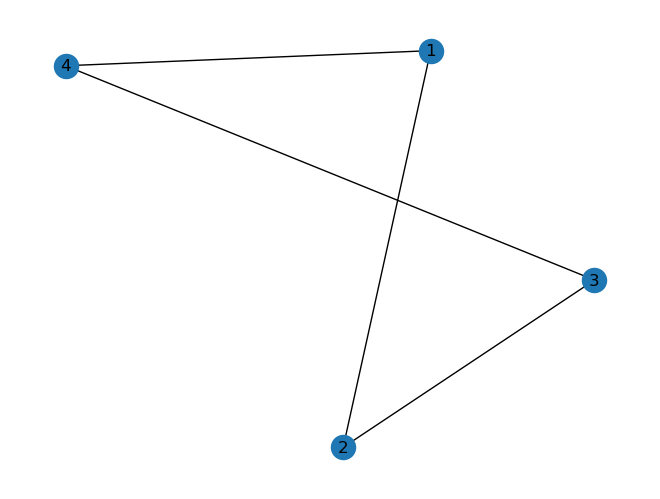

Done
Original: 15625
Tensor Network: 12312
Rel error: 8.992486564253363e-06


In [742]:
G = nx.Graph()
G.add_edges_from([(1, 2), (2, 3), (3, 4), (4, 1)])
nx.draw(G, with_labels=True)
plt.show()

objective = torch.randn(10,15,6,7, device=device)

ntn = TN(G, [10,15,6,7], [18,18,18,18])
TN.als(ntn, objective, 1e-3, iter_num=500)

# print(TN.eval(tn))
err = torch.norm(objective - TN.eval(ntn)).item()
rel_err = err / torch.norm(objective).item()

print("Original: " + str(torch.numel(obj)))
print("Tensor Network: " + str(ntn.get_tn_size()))
print("Rel error: " + str(rel_err))
